<h1 style="font-family:Times New Roman; font-size: 300%"><center>FYS5429 Spring 2025 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Generating plots for the Quantum Dot systems</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We first import packages and define functions
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pickle
from cycler import cycler
plt.rcParams.update({
    # Canvas and figure
    'figure.figsize': (12, 9),
    'figure.dpi': 100,
    'figure.facecolor': 'white',
    'axes.facecolor': '#faf9f6',  # Softer off-white
    'axes.edgecolor': '#2e2e2e',

    # Grid
    'axes.grid': True,
    'grid.color': '#d3d3d3',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,

    # Font and text
    'font.size': 20,
    'font.family': 'serif',
    'mathtext.fontset': 'stix',
    'axes.titlesize': 35,
    'axes.labelsize': 36,
    'figure.titlesize': 36,
    'axes.titleweight': 'semibold',
    'axes.labelweight': 'medium',
    'axes.titley': 1.02,

    # Lines
    'lines.linewidth': 2.5,
    'lines.markersize': 8,

    # Ticks
    'xtick.labelsize': 32,
    'ytick.labelsize': 32,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 20,
    'ytick.major.size': 20,

    # Color cycle
    'axes.prop_cycle': cycler('color', [
        '#1f77b4',  # muted blue
        '#a13333',  # deep red wine
        '#8c564b',  # earthy brown
        '#2ca02c',  # forest green
        '#9467bd',  # muted purple
        '#17becf',  # calm cyan
    ])
})


In [2]:
import numpy as np
import math
from math import factorial, sqrt, pi
from scipy.integrate import simps
import torch
import functorch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import os
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
    
from Config import PARAMS

In [3]:
PARAMS

{'hidden_dim': 64,
 'n_layers': 3,
 'act_fn': GELU(approximate='none'),
 'learning_rate': 0.0001,
 'N_collocation': 2000,
 'n_epochs': 3000,
 'n_epochs_norm': 200,
 'E': 0.44079,
 'V': 1,
 'd': 2,
 'device': 'cpu',
 'n_particles': 2,
 'nx': 1,
 'ny': 1,
 'dimensions': 2,
 'omega': 0.1,
 'L': 8.0,
 'L_E': 9.0,
 'n_grid': 30,
 'batch_size': 1000,
 'n_samples': 100000}

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device="cpu"

In [5]:
PARAMS["n_particles"] = 2
PARAMS["omega"] = 1.0
PARAMS["device"] = device
PARAMS["nx"] = 2
PARAMS["ny"] = 2
PARAMS["E"] = 3.0
PARAMS["N_collocation"] = 1000
PARAMS["L"]=5
PARAMS["L_E"]=5

In [6]:
from master_functions import *
from PINN import PINN
torch.set_num_threads(1)
locals().update(PARAMS)

In [7]:
xgrid = np.linspace(-L, L, n_grid)
ygrid = np.linspace(-L, L, n_grid)
n_electrons = n_particles      # Two electrons, occupying the same spatial orbital (opposite spins)

# 1) Build the 2D harmonic oscillator basis
basis_2d = initialize_harmonic_basis_2d(nx, ny, xgrid, ygrid,omega)
n_basis = basis_2d.shape[1]
print(f"2D Basis: n_points = {basis_2d.shape[0]}, n_basis = {n_basis}")

# 2) Compute one-electron integrals in 2D
print("Computing one-electron integrals (Hcore)...")
Hcore_2d = one_electron_integral_2d(basis_2d, xgrid, ygrid,omega)
print("One-electron integrals computed.")

# 3) Build the 2D Gaussian interaction potential
V_SD = 0.0     # Interaction strength
sigma = 0.5  # Gaussian width
print("Building 2D Gaussian interaction matrix...")
V_interaction_2d = gaussian_interaction_potential_2d(xgrid, ygrid, V_SD, sigma)

# 4) Compute two-electron integrals in 2D
print("Computing two-electron integrals...")
two_body_2d = compute_two_body_integrals_2d(basis_2d, V_interaction_2d, xgrid, ygrid)
print("Two-electron integrals computed.")

# 5) Run closed-shell Hartree-Fock for 2 electrons in the ground state
print("Starting closed-shell Hartree-Fock iterations...")
C_occ, orbital_energies = hartree_fock_2d(n_electrons, basis_2d, xgrid, ygrid,
                                          Hcore_2d, two_body_2d)
print("Occupied Orbital Energies:", orbital_energies)
C_occ = torch.Tensor(C_occ)
C_occ.to(device)

2D Basis: n_points = 900, n_basis = 4
Computing one-electron integrals (Hcore)...
One-electron integrals computed.
Building 2D Gaussian interaction matrix...
Computing two-electron integrals...
Computing integrals for basis p=0
Computing integrals for basis p=1
Computing integrals for basis p=2
Computing integrals for basis p=3
Two-electron integrals computed.
Starting closed-shell Hartree-Fock iterations...
Iteration 0: ΔD = 0.000e+00
Final HF Energy = 1.985283
Occupied Orbital Energies: [0.99264147]


tensor([[ 1.0000e+00],
        [ 2.1210e-16],
        [ 1.8756e-16],
        [-1.0545e-17]])

In [8]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=64, n_layers=4, act=nn.GELU(),dL=5,init='custom').to(device)
#state_dict = torch.load("testing.pth", map_location="cpu")
#f_net.load_state_dict(state_dict)
f_net.to(device)

PINN(
  (phi): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=64, out_features=5, bias=True)
  )
  (psi): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=64, out_features=5, bias=True)
  )
  (rho): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=T

In [9]:
def psi_fn_with_fnet(f_net, x_batch, C_occ, device=device):
    """
    Compute the wavefunction for a single configuration.
    Args:
        x_single (torch.Tensor): (n_particles, d) with requires_grad=True.
    Returns:
        Scalar tensor for psi.
    """
    #SD_val = slater_determinant_closed_shell(x_batch, C_occ, ny, nx)
    #print(SD_val.shape)
    #
    f_val = torch.exp(f_net(x_batch))
    psi_val = f_val#(SD_val * f_val)
    return psi_val

In [17]:
C_occ = torch.load("SD_occ.pth")

In [142]:
def construct_grid_configurations(n_particles, dims, Ngrid, L, device="cpu"):
    """
    Constructs configurations on a 2D grid for a system with n_particles (each with dims=2),
    where the first electron's position is varied over a grid on [-L,L]^2 and all
    the remaining electrons are fixed at (0, 0).
    
    Args:
        n_particles (int): Total number of electrons.
        dims (int): Dimension per electron (should be 2).
        Ngrid (int): Number of grid points per coordinate.
        L (float): Range for the grid (each coordinate in [-L,L]).
        device (str): Device to use.
    
    Returns:
        x_configs (torch.Tensor): Tensor of shape (Ngrid*Ngrid, n_particles, dims).
        X (np.ndarray), Y (np.ndarray): Meshgrid arrays for electron 0's x and y coordinates (bin edges).
    """
    assert dims == 2, "This function is designed for a 2D system (dims must be 2)."
    
    # Create a 1D grid for electron 0's x and y coordinates.
    x_vals = torch.linspace(-L, L, Ngrid, device=device)
    y_vals = torch.linspace(-L, L, Ngrid, device=device)
    # Meshgrid over electron 0's coordinates.
    X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')  # Each of shape (Ngrid, Ngrid)
    
    # Flatten to get a list of positions for electron 0: shape (Ngrid*Ngrid, 2)
    e0_coords = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)  # (Ngrid*Ngrid, 2)
    
    # For the remaining electrons, fix them at (0,0) (or any reference point you choose).
    fixed_pos = torch.zeros(n_particles - 1, dims, device=device)  # shape: (n_particles-1, 2)
    
    # Repeat e0_coords for each grid point: we want shape (Ngrid*Ngrid, n_particles, 2)
    # The first electron gets e0_coords, and the others get fixed_pos.
    N_total = e0_coords.shape[0]
    # Expand e0_coords to shape (N_total, 1, 2)
    e0_coords_expanded = e0_coords.unsqueeze(1)
    # Expand fixed_pos to shape (1, n_particles-1, 2) and then repeat for each grid point.
    others_expanded = fixed_pos.unsqueeze(0).expand(N_total, -1, -1)
    
    # Concatenate along the particle dimension.
    x_configs = torch.cat([e0_coords_expanded, others_expanded], dim=1)
    # x_configs shape: (Ngrid*Ngrid, n_particles, 2)
    return x_configs, X.detach().cpu().numpy(), Y.detach().cpu().numpy()

def plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device="cpu",title="WaveFunction_Grid"):
    """
    Evaluate psi_fn on a grid and plot |Ψ|^2 as a heatmap.
    
    Here, psi_fn is expected to take input x of shape (Ngrid*Ngrid, n_particles, dims)
    and return a tensor of shape (Ngrid*Ngrid, 1). The plot is made with respect to the
    x-y coordinates of electron 0.
    
    Args:
        psi_fn (callable): Function computing Ψ(x) for x of shape (batch, n_particles, 2).
        n_particles (int): Total number of electrons.
        Ngrid (int): Number of grid points per coordinate.
        L (float): Range for the grid (each coordinate in [-L,L]).
        device (str): Device.
    """
    # Construct configurations on the grid.
    x_configs, X, Y = construct_grid_configurations(n_particles, 2, Ngrid, L, device)
    # Evaluate wavefunction.
    psi_vals = psi_fn_with_fnet(f_net, x_configs, C_occ).detach()  # shape: (Ngrid*Ngrid, 1)
    density = psi_vals.abs() ** 2  # (Ngrid*Ngrid, 1)
    
    # Reshape density into a 2D array for electron 0's grid.
    density_grid = density.view(Ngrid, Ngrid).cpu().numpy()
    
    # Plot the heatmap.
    plt.figure()
    plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
    plt.xlabel("x coordinate (electron 0)")
    plt.ylabel("y coordinate (electron 0)")
    plt.title("Wavefunction Density Heatmap")
    plt.colorbar(label="|Ψ(x)|²")
    plt.savefig(f"Results/QuantumDots/{title}", bbox_inches='tight')
    plt.show()

/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:71: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="|Ψ(x)|²")


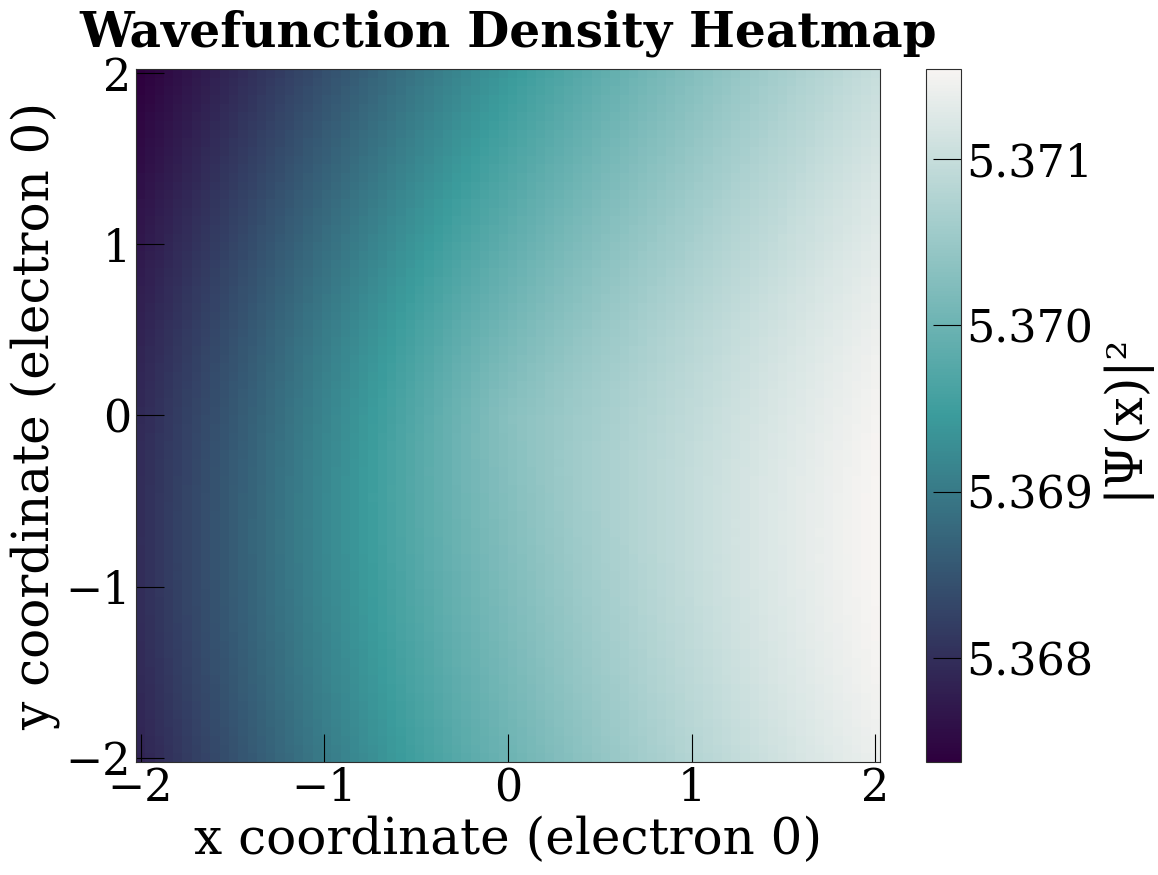

In [172]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=64, n_layers=2, act=nn.Sigmoid(),dL=5,init='xavier').to(device)
from matplotlib.colors import LinearSegmentedColormap
thesis_viridial = LinearSegmentedColormap.from_list("thesis_viridial", [
    "#2e003e",  # deep violet
    "#3b9c9c",  # dusty teal
    #"#3a6ea5",  # slate blue
    "#f7f4f2",  # ivory white
], N=256)

# --- Example usage ---
if __name__ == '__main__':
    device = "cpu"
    n_particles = 2   # e.g., for a two-electron system
    Ngrid = 80        # Grid resolution per coordinate.
    L = 2           # Grid ranges: [-3, 3] for x and y.
    
    plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device,title="Wavefunction_untrianed_Sigmoid")


/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:71: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="|Ψ(x)|²")


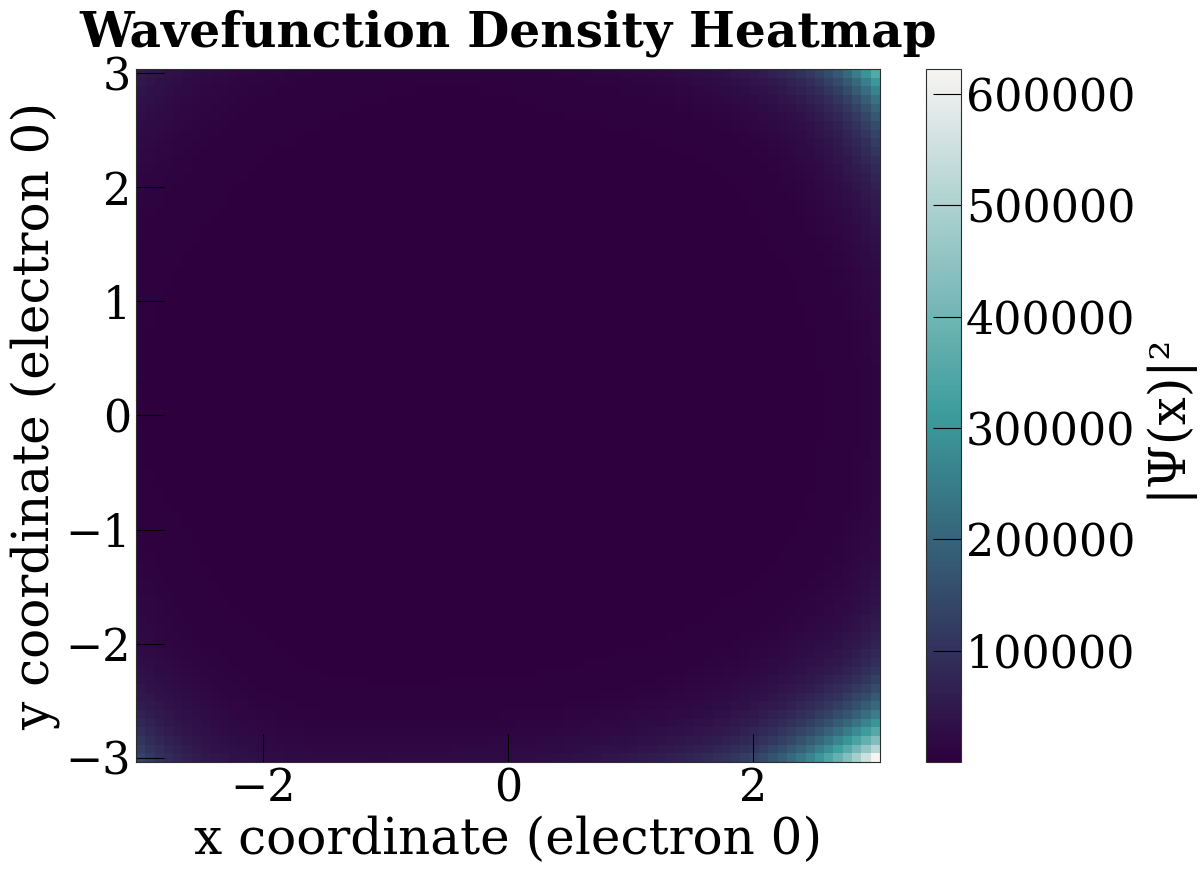

In [54]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=64, n_layers=4, act=nn.GELU(),dL=5,init='he').to(device)
from matplotlib.colors import LinearSegmentedColormap
thesis_viridial = LinearSegmentedColormap.from_list("thesis_viridial", [
    "#2e003e",  # deep violet
    "#3b9c9c",  # dusty teal
    #"#3a6ea5",  # slate blue
    "#f7f4f2",  # ivory white
], N=256)

# --- Example usage ---
if __name__ == '__main__':
    device = "cpu"
    n_particles = 2   # e.g., for a two-electron system
    Ngrid = 80        # Grid resolution per coordinate.
    L = 3           # Grid ranges: [-3, 3] for x and y.
    
    plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device,title="Wavefunction_untrained_he")


/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:71: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="|Ψ(x)|²")


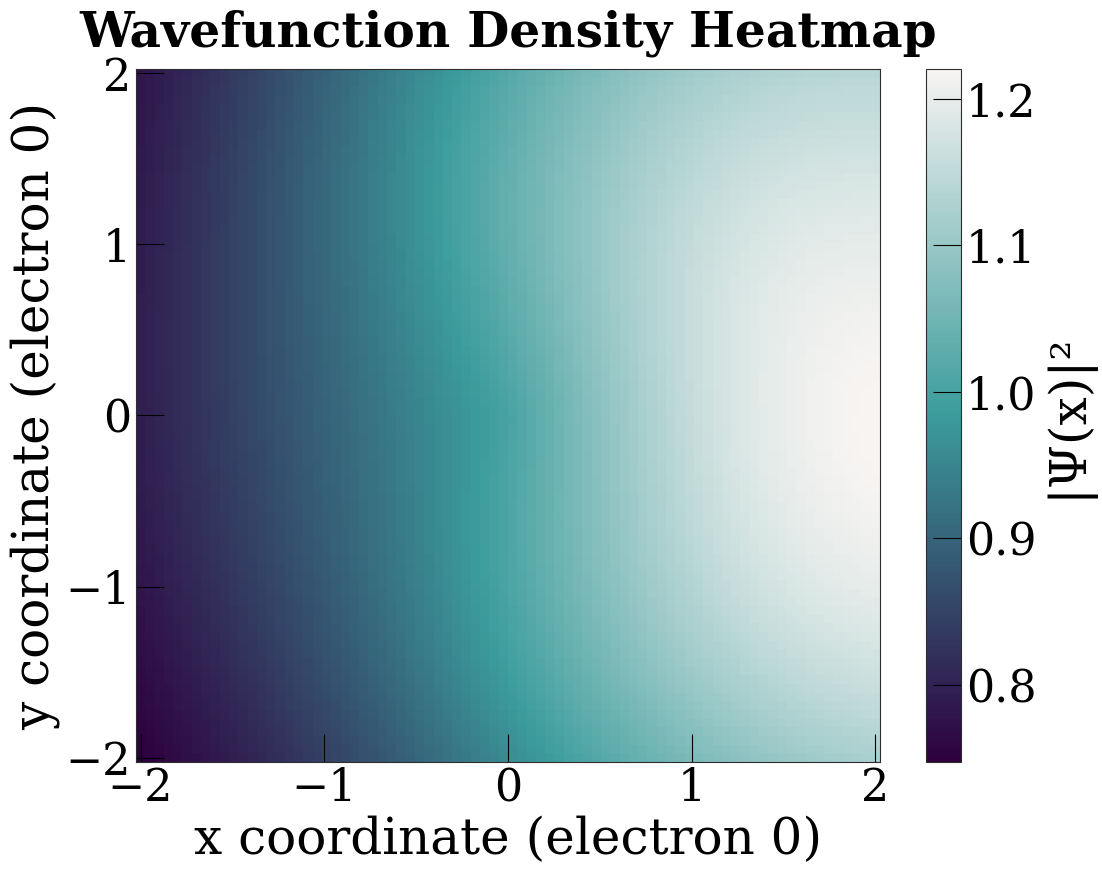

In [165]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=64, n_layers=2, act=nn.Tanh(),dL=5,init='xavier').to(device)
from matplotlib.colors import LinearSegmentedColormap
thesis_viridial = LinearSegmentedColormap.from_list("thesis_viridial", [
    "#2e003e",  # deep violet
    "#3b9c9c",  # dusty teal
    #"#3a6ea5",  # slate blue
    "#f7f4f2",  # ivory white
], N=256)

# --- Example usage ---
if __name__ == '__main__':
    device = "cpu"
    n_particles = 2   # e.g., for a two-electron system
    Ngrid = 80        # Grid resolution per coordinate.
    L = 2           # Grid ranges: [-3, 3] for x and y.
    
    plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device,title="Wavefunction_untrianed_Tanh")


/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:71: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
/var/folders/22/r_0rd109347dhcsf5w9p2y3w0000gn/T/ipykernel_11538/3680510905.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="|Ψ(x)|²")


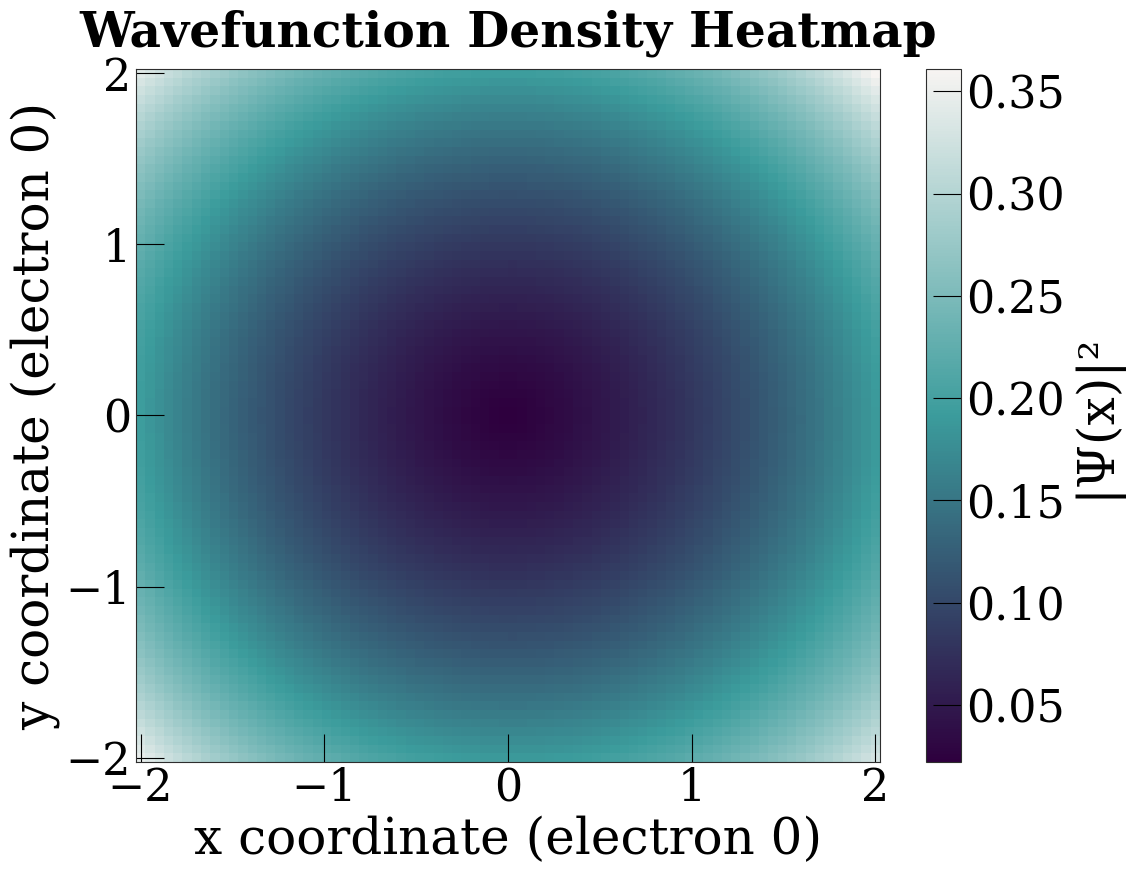

In [55]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=64, n_layers=2, act=nn.GELU(),dL=5,init='custom').to(device)
state_dict = torch.load("2p_1.pth", map_location="cpu")
f_net.load_state_dict(state_dict)
f_net.to(device)
from matplotlib.colors import LinearSegmentedColormap
thesis_viridial = LinearSegmentedColormap.from_list("thesis_viridial", [
    "#2e003e",  # deep violet
    "#3b9c9c",  # dusty teal
    #"#3a6ea5",  # slate blue
    "#f7f4f2",  # ivory white
], N=256)

# --- Example usage ---
if __name__ == '__main__':
    device = "cpu"
    n_particles = 2   # e.g., for a two-electron system
    Ngrid = 80        # Grid resolution per coordinate.
    L = 2           # Grid ranges: [-3, 3] for x and y.
    
    plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device,title="Wavefunction_trained")


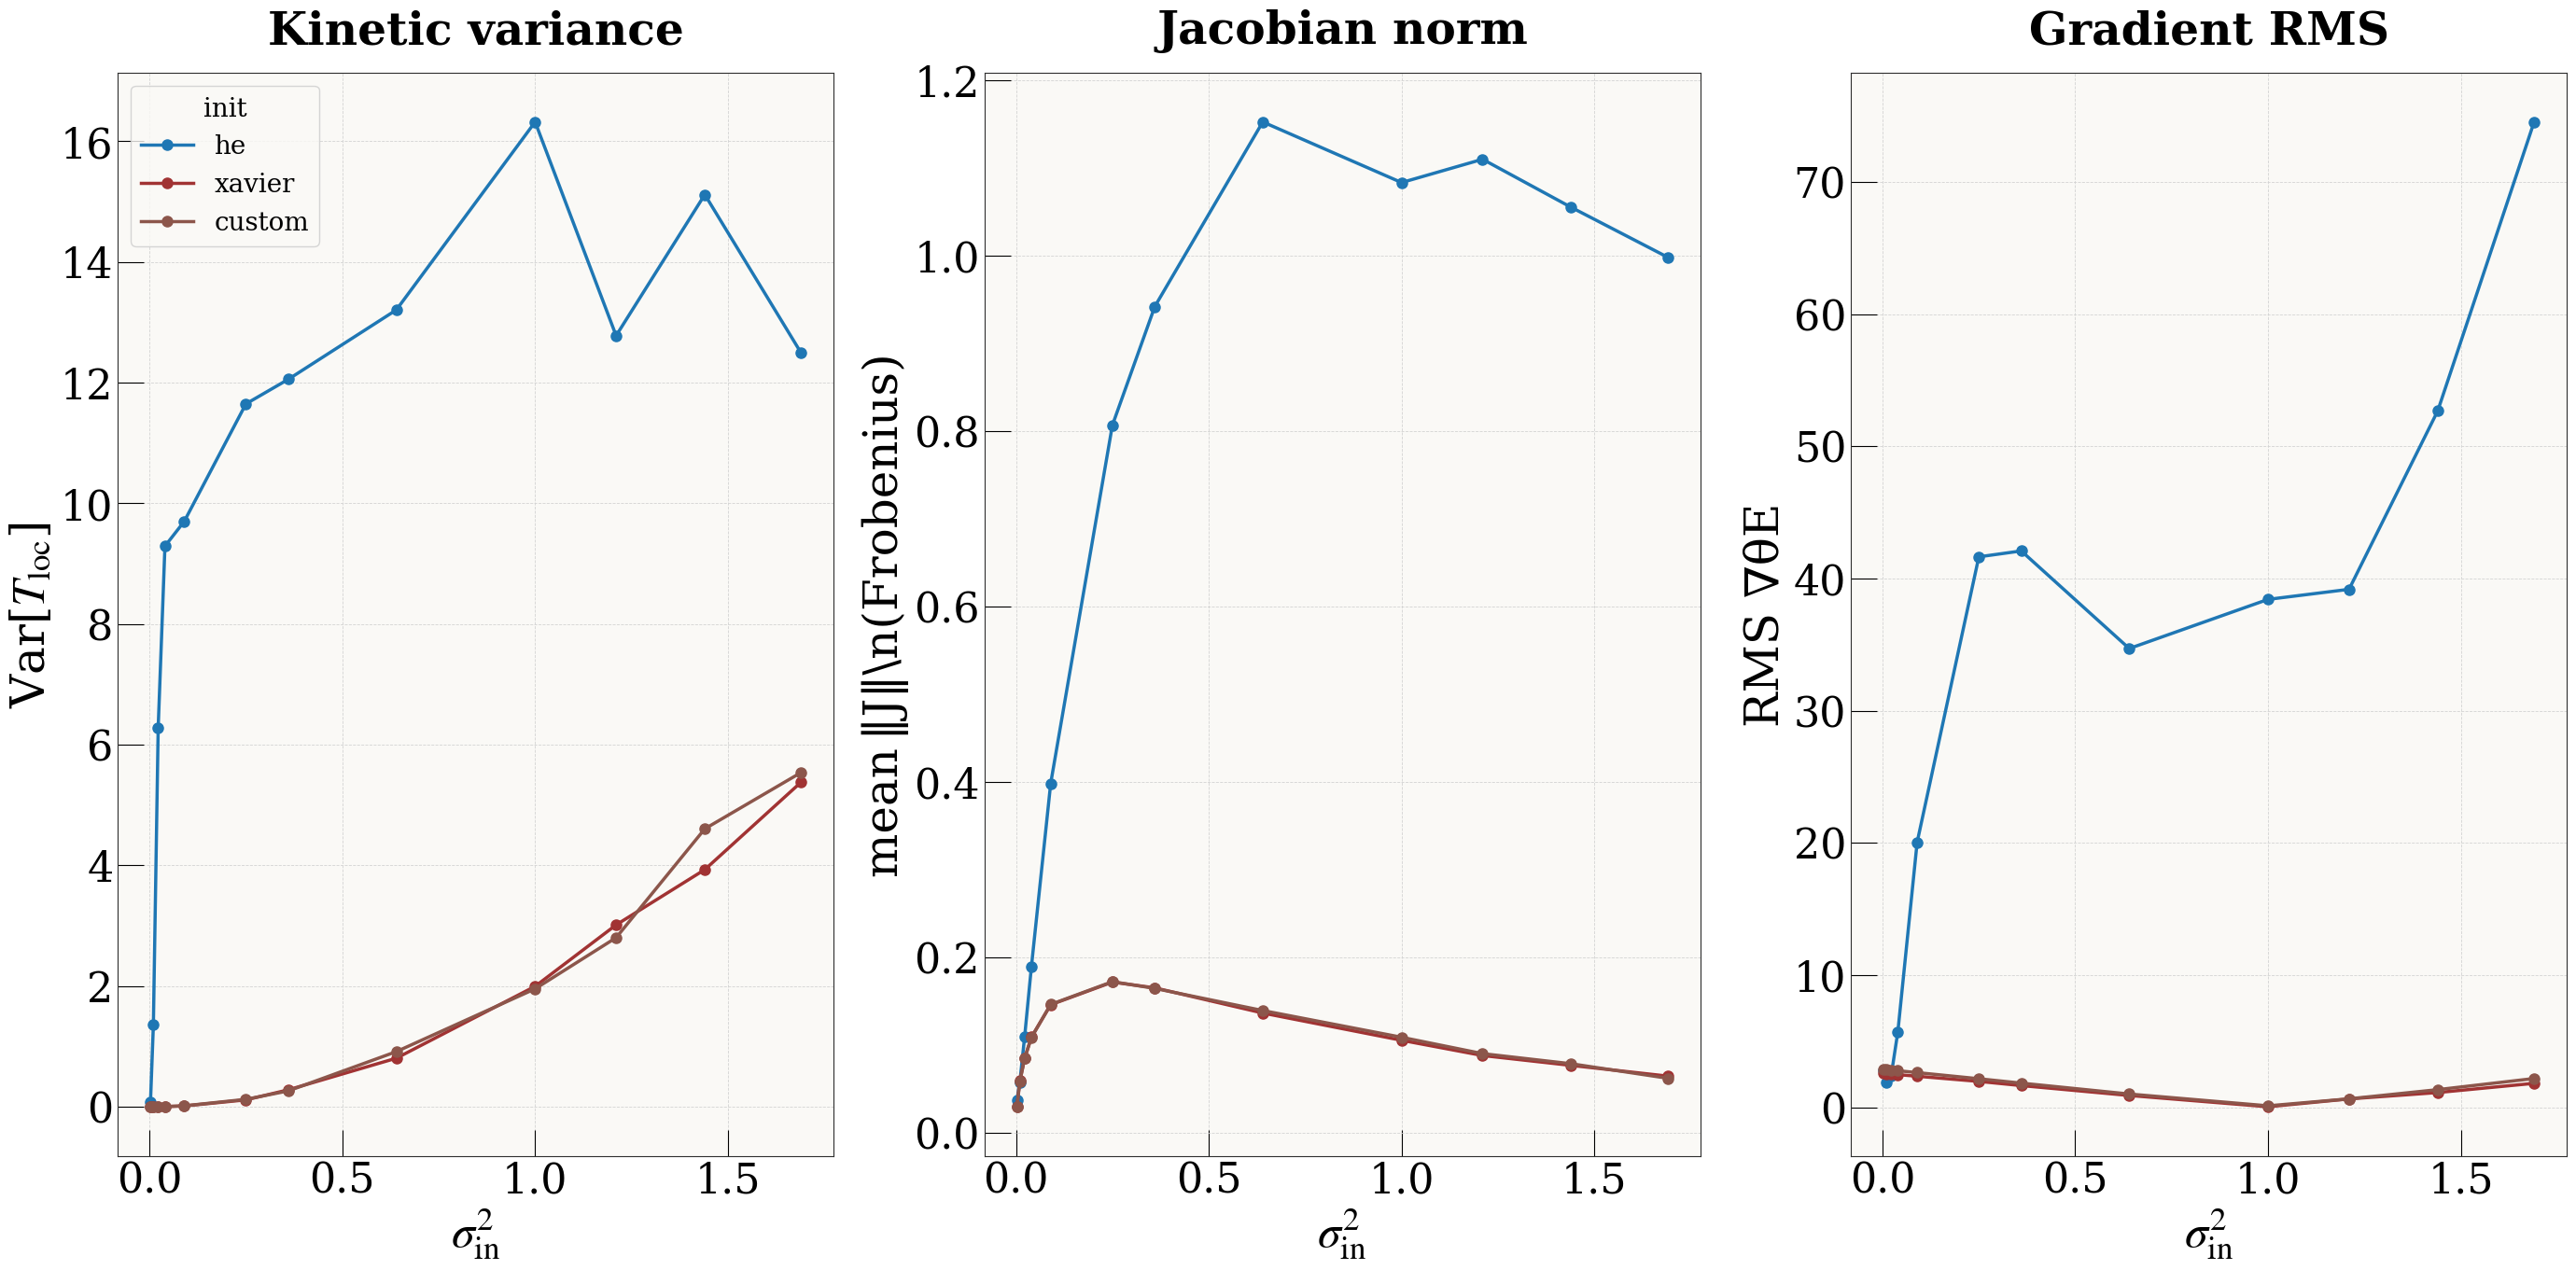

In [142]:
# ────────────────────────────────────────────────────────────────────
#  stability_probe_full.py
# ────────────────────────────────────────────────────────────────────
import torch, numpy as np, matplotlib.pyplot as plt
from typing import List, Tuple

# ---------------- Coulomb helper ------------------------------------
def compute_coulomb_interaction(x: torch.Tensor, V: float, eps: float = 1e-12):
    b, n, _ = x.shape
    i, j = torch.triu_indices(n, n, 1, device=x.device)
    rij = torch.norm(x[:, i] - x[:, j], dim=-1).clamp_min_(eps)
    return (V / rij).sum(dim=1, keepdim=True)

# ---------------- Laplacian helper -----------------------------------
def _laplacian_psi(psi: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    lap = torch.zeros_like(psi)
    _, n, d = x.shape
    for i in range(n):
        for mu in range(d):
            second = torch.autograd.grad(
                grad[:, i, mu].sum(), x, retain_graph=True
            )[0][:, i, mu]
            lap += second
    return lap            # (batch,)

# ---------------- Main probe ----------------------------------------
def stability_probe(
    sigmas: List[float],
    n_samples: int,
    *,
    f_net: torch.nn.Module,
    psi_fn,
    C_occ: torch.Tensor,
    omega: float,
    V: float,
    device,
    dtype
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns arrays: kinetic-var, jacobian-norm, param-grad-rms."""
    kin_var, jac_norm, g_rms = [], [], []

    # Remember original requires_grad flags
    original_flags = [p.requires_grad for p in f_net.parameters()]
    f_net.requires_grad_(True)                 # enable grads

    for sigma in sigmas:
        x = torch.randn(n_samples, 2, 2, device=device, dtype=dtype) * sigma
        x.requires_grad_(True)

        # ψ (works for either ψ or (φ,sign))
        out = psi_fn(f_net, x, C_occ, PARAMS)
        psi = (out[1] * torch.exp(out[0])).squeeze() if isinstance(out, (tuple, list)) else out.squeeze()

        grad = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
        lap  = _laplacian_psi(psi, x)

        kin_tensor = -0.5 * lap / psi                    # keep graph
        kin_var.append(kin_tensor.detach().var().item()) # safe for stats

        jac_norm.append(grad.norm(dim=(1, 2)).mean().item())

        local_E = kin_tensor + 0.5*omega**2*(x**2).sum(dim=(1,2)) \
                    + compute_coulomb_interaction(x, V).squeeze()
        loss = local_E.mean()
        grads = torch.autograd.grad(
            loss, list(f_net.parameters()), allow_unused=True
        )
        total = sum((g.detach()**2).sum() for g in grads if g is not None)
        g_rms.append(torch.sqrt(total).item())

    # restore original requires_grad flags
    for p, flag in zip(f_net.parameters(), original_flags):
        p.requires_grad_(flag)

    return np.array(kin_var), np.array(jac_norm), np.array(g_rms)

# ---------------- Convenience plotting wrapper ----------------------
def run_stability_probe(sigmas, n_samples):
    device = next(f_net.parameters()).device
    dtype  = next(f_net.parameters()).dtype

    kin_var, jac_norm, g_rms = stability_probe(
        sigmas, n_samples,
        f_net=f_net,
        psi_fn=psi_fn,
        C_occ=C_occ,
        omega=omega,
        V=V,
        device=device,
        dtype=dtype,
    )

    sigma_sq = np.square(sigmas)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    axes[0].plot(sigma_sq, kin_var, 'o-')
    axes[0].set(xlabel=r'input var $\sigma_{in}^2$', ylabel='Var[$T_{loc}$]',
                title='Kinetic variance')

    axes[1].plot(sigma_sq, jac_norm, 'o-')
    axes[1].set(xlabel=r'$\sigma_{in}^2$', ylabel=r'$\langle\|J\|\rangle$',
                title='Jacobian norm')

    axes[2].plot(sigma_sq, g_rms, 'o-')
    axes[2].set(xlabel=r'$\sigma_{in}^2$', ylabel='RMS ∇θ E',
                title='Parameter-grad RMS')

    for ax in axes:
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    return kin_var, jac_norm, g_rms

# ---------------- Example call --------------------------------------
sigmas = [0.05,0.1, 0.15,0.2, 0.3, 0.5, 0.6, 0.8, 1.0, 1.1,1.2, 1.3]
# kin_var, jac_norm, g_rms = run_stability_probe(sigmas, n_samples=10_000)

# ---------------------------------------------------------------------
#  USER: make sure the following symbols are already defined in your notebook:
#    f_net, psi_fn, C_occ, omega, V, params
# ---------------------------------------------------------------------
inits = ['he', 'xavier', 'custom']
fig, axes = plt.subplots(1, 3, figsize=(28, 14), sharex=False)
sigma_sq = np.square(sigmas)
for init in inits:
    f_net_current = PINN(n_particles=n_particles, d=d,
                         hidden_dim=64, n_layers=4,
                         act=nn.GELU(), dL=5, init=init).to(device)

    # ---- run the probe for *this* network ------------------------------
    kin_var, jac_norm, g_rms = stability_probe(
        sigmas,
        n_samples=1_000,
        f_net=f_net_current,          # <- pass the fresh model
        psi_fn=psi_fn,
        C_occ=C_occ,
        omega=omega,
        V=V,
        device=device,
        dtype=dtype,
    )
    # ---- plot all three metrics on the shared 1×3 grid -----------------
    axes[0].plot(sigma_sq, kin_var,  marker='o', label=init)
    axes[1].plot(sigma_sq, jac_norm, marker='o')
    axes[2].plot(sigma_sq, g_rms,    marker='o')

# ---- cosmetics --------------------------------------------------------
axes[0].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"Var[$T_{\rm loc}$]",
            title="Kinetic variance")
axes[1].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"mean ‖J‖\n(Frobenius)",
            title="Jacobian norm")
axes[2].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"RMS ∇θE",
            title="Gradient RMS")

for ax in axes:
    ax.grid(True)

axes[0].legend(title="init")       # show which colour is which
plt.tight_layout()
plt.show()

In [135]:
# ──────────────────────────────────────────────────────────────────────
#  stability_probe_PDE.py
#  • Uses your PDE loss (residual of Schrödinger-equation + norm penalty)
#  • Expects PARAMS = {"E": target_energy, "norm_factor": λ_norm, ...}
#  • Diagnostics:  kinetic-variance, Jacobian-norm, RMS ∇θ loss
#  • One call → three-column figure
# ──────────────────────────────────────────────────────────────────────
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from typing import List, Tuple

# ---------------------------------------------------------------------
#  Fast Coulomb (batched, vectorised)
# ---------------------------------------------------------------------
def compute_coulomb_interaction(x: torch.Tensor, V: float, eps: float = 1e-12):
    b, n, _ = x.shape
    i, j = torch.triu_indices(n, n, 1, device=x.device)
    rij = torch.norm(x[:, i] - x[:, j], dim=-1).clamp_min_(eps)
    return (V / rij).sum(dim=1, keepdim=True)      # (batch,1)

# ---------------------------------------------------------------------
#  Laplacian helper (second derivatives only, no mixed terms)
# ---------------------------------------------------------------------
def _laplacian_psi(psi: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]  # (b,N,d)
    lap  = torch.zeros_like(psi)
    _, n, d = x.shape
    for i in range(n):
        for mu in range(d):
            lap += torch.autograd.grad(
                grad[:, i, mu].sum(), x, retain_graph=True
            )[0][:, i, mu]
    return lap                                # (batch,)

# ---------------------------------------------------------------------
#  Your PDE loss
# ---------------------------------------------------------------------
def _pde_loss(
    x: torch.Tensor,
    *,
    f_net,
    psi_fn,
    C_occ,
    omega: float,
    V: float,
    E_target: float,
    norm_factor: float = 1.0,
) -> torch.Tensor:
    # ψ and ∇²ψ
    psi, lap = compute_laplacian_fast(psi_fn, f_net, x, C_occ)  # (b,1) each

    norm      = torch.norm(psi, p=2)
    psi_norm  = psi / norm

    V_harm    = 0.5 * omega**2 * (x**2).sum(dim=(1, 2), keepdim=True)
    V_int     = compute_coulomb_interaction(x, V)
    V_total   = V_harm + V_int

    H_psi     = -0.5 * lap + V_total * psi_norm
    residual  = H_psi - E_target * psi_norm

    loss_pde  = torch.mean(residual**2)
    return loss_pde #+ loss_norm               # scalar

# ---------------------------------------------------------------------
#  Probe returns kinetic variance, Jacobian norm, RMS parameter grad
# ---------------------------------------------------------------------
def stability_probe(
    sigmas: List[float],
    n_samples: int,
    *,
    f_net: nn.Module,
    psi_fn,
    C_occ: torch.Tensor,
    omega: float,
    V: float,
    device,
    dtype,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    kin_var, jac_norm, g_rms = [], [], []

    # Remember original requires_grad flags and enable grads
    original_flags = [p.requires_grad for p in f_net.parameters()]
    f_net.requires_grad_(True)

    for sigma in sigmas:
        x = (torch.randn(n_samples, 2, 2, device=device, dtype=dtype) * sigma
             ).requires_grad_(True)

        # ψ and its gradient
        out = psi_fn(f_net, x, C_occ, PARAMS)
        psi = (out[1] * torch.exp(out[0])).squeeze() if isinstance(out, (tuple, list)) else out.squeeze()

        grad = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
        lap  = _laplacian_psi(psi, x)

        # --- Diagnostics ------------------------------------------------
        kin_tensor = -0.5 * lap /psi                      # keep graph
        kin_var.append(kin_tensor.detach().var().item())

        jac_norm.append(grad.norm(dim=(1, 2)).mean().item())

        loss = _pde_loss(
            x,
            f_net=f_net,
            psi_fn=psi_fn,
            C_occ=C_occ,
            omega=omega,
            V=V,
            E_target=PARAMS["E"],
            norm_factor=PARAMS.get("norm_factor", 1.0),
        )
        grads = torch.autograd.grad(
            loss, list(f_net.parameters()), allow_unused=True
        )
        total = sum((g.detach()**2).sum() for g in grads if g is not None)
        g_rms.append(torch.sqrt(total).item())

    # restore flags
    for p, flag in zip(f_net.parameters(), original_flags):
        p.requires_grad_(flag)

    return np.array(kin_var), np.array(jac_norm), np.array(g_rms)

# ---------------------------------------------------------------------
#  Wrapper that builds combined 1×3 figure for a given network
# ---------------------------------------------------------------------
def run_stability_probe(sigmas, n_samples, *, f_net):
    device = next(f_net.parameters()).device
    dtype  = next(f_net.parameters()).dtype

    kin_var, jac_norm, g_rms = stability_probe(
        sigmas, n_samples,
        f_net=f_net,
        psi_fn=psi_fn,
        C_occ=C_occ,
        omega=omega,
        V=V,
        device=device,
        dtype=dtype,
    )

    sigma_sq = np.square(sigmas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].plot(sigma_sq, kin_var, marker='o')
    axes[0].set(xlabel=r"$\sigma_{in}^2$", ylabel="Var[$T_{loc}$]",
                title="Kinetic variance")

    axes[1].plot(sigma_sq, jac_norm, marker='o')
    axes[1].set(xlabel=r"$\sigma_{in}^2$", ylabel=r"mean ‖J‖",
                title="Jacobian norm")

    axes[2].plot(sigma_sq, g_rms, marker='o')
    axes[2].set(xlabel=r"$\sigma_{in}^2$", ylabel="RMS ∇θ loss",
                title="Gradient RMS")

    for ax in axes: ax.grid(True)
    plt.tight_layout()
    plt.show()

    return kin_var, jac_norm, g_rms

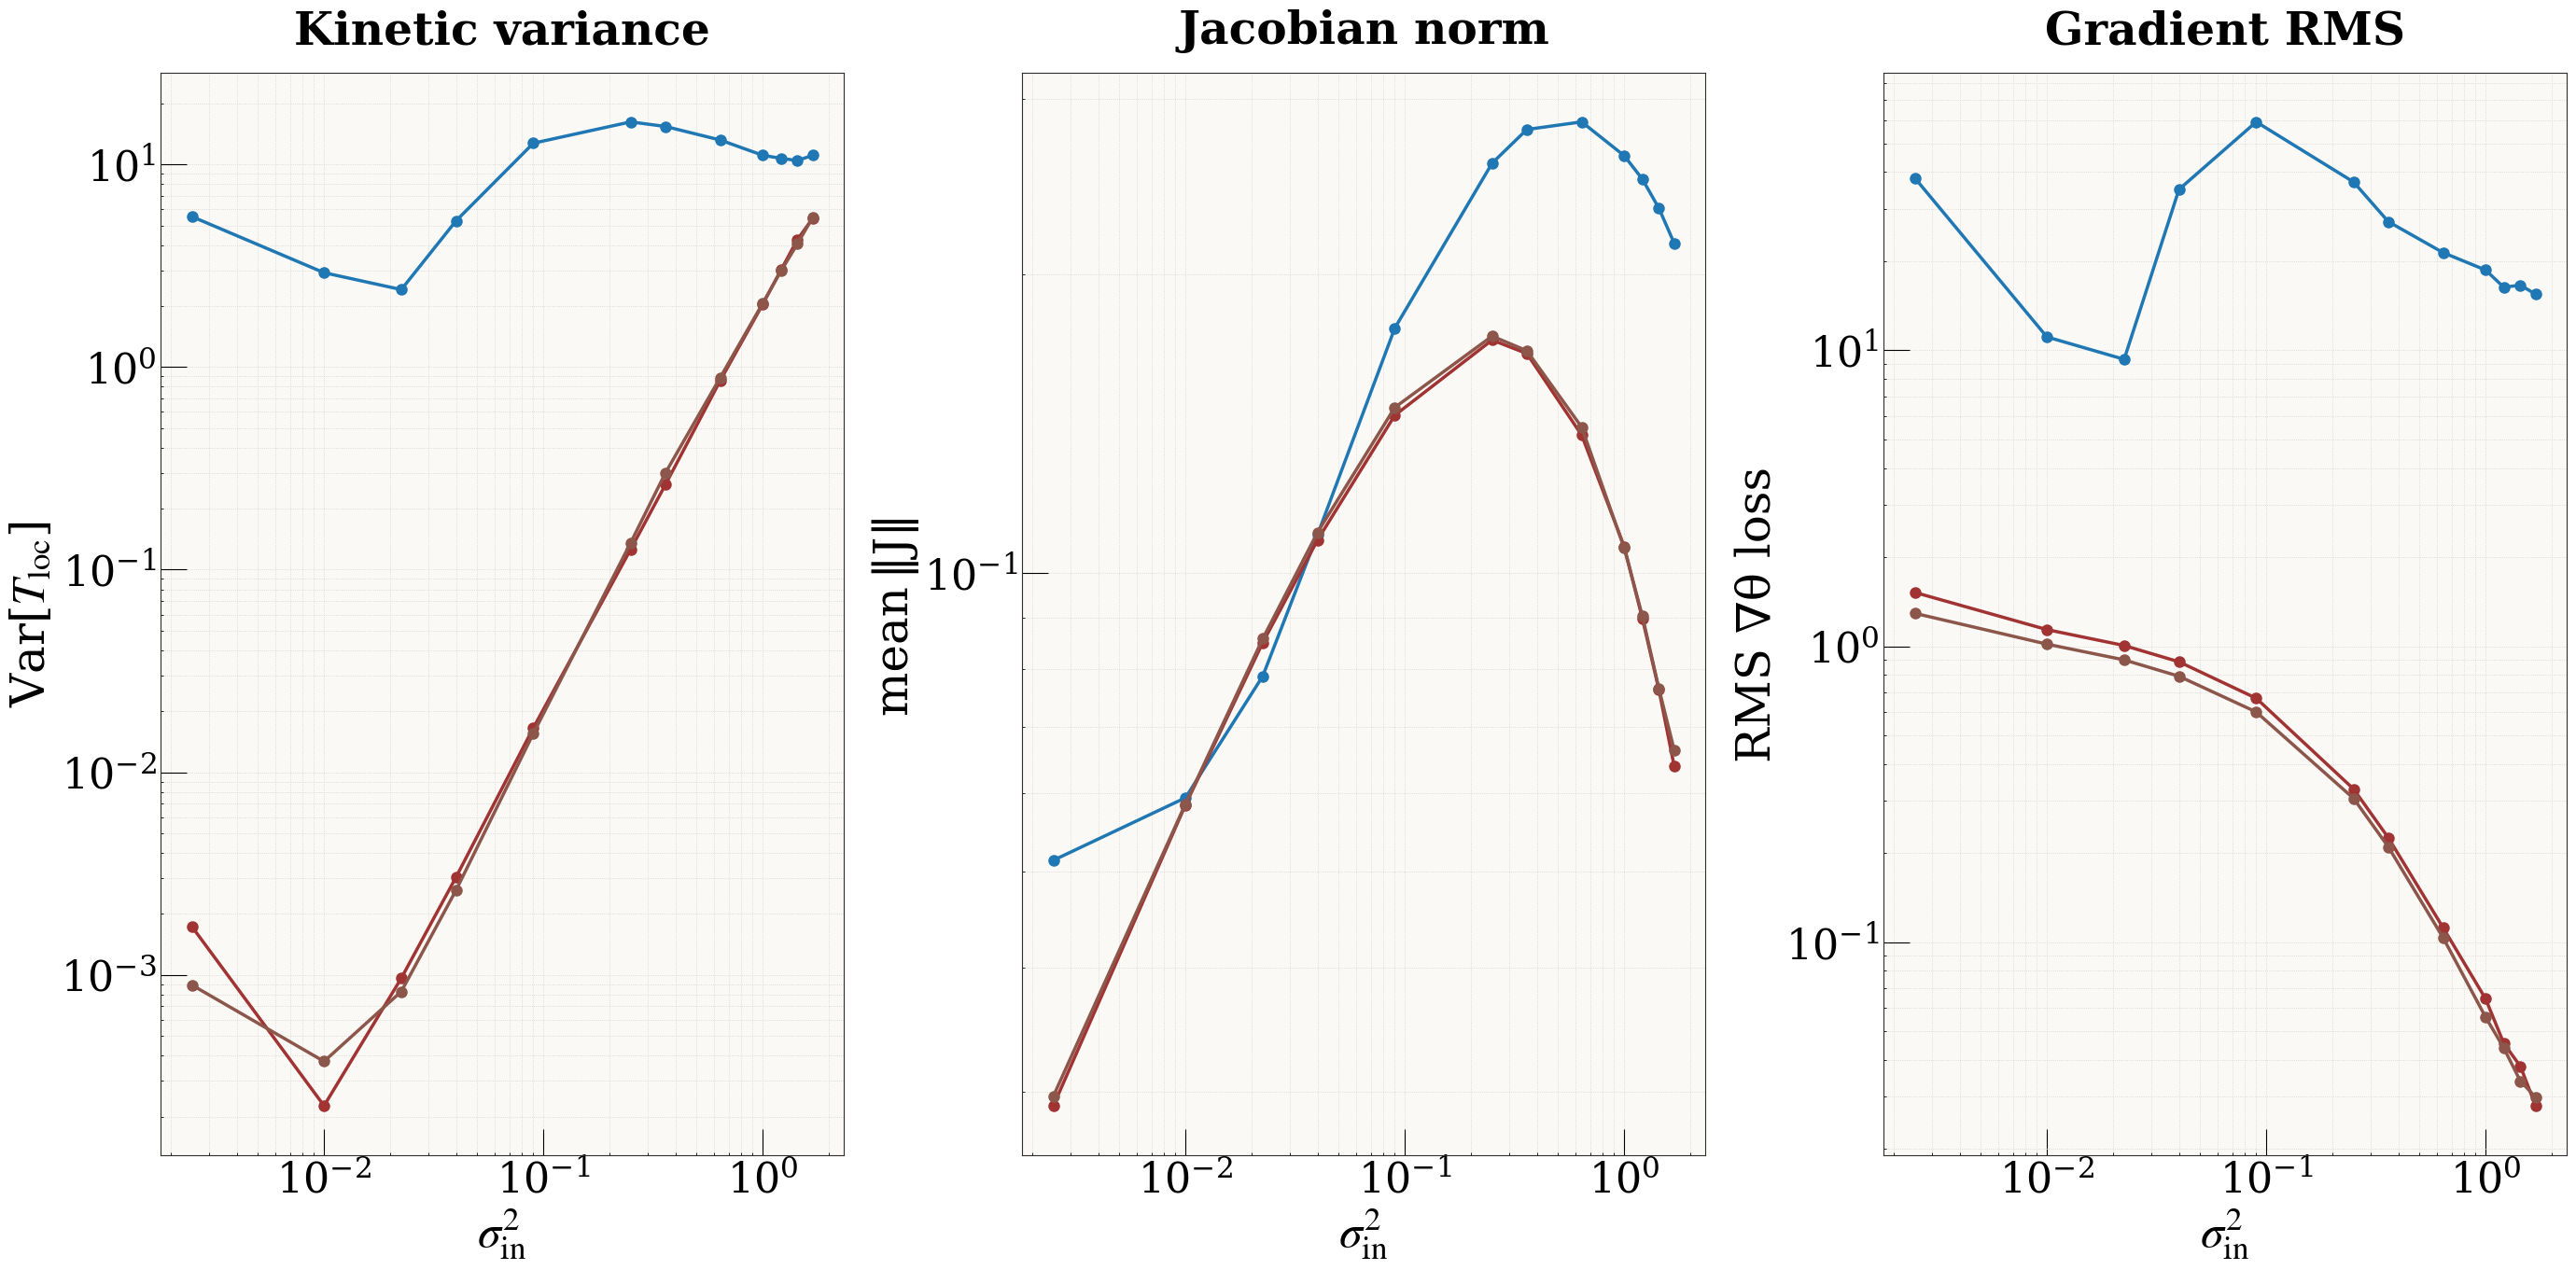

In [77]:
sigmas   = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0, 1.1, 1.2, 1.3]
sigma_sq = np.square(sigmas)           # x-axis (always positive)

inits = ['he', 'xavier', 'lecun']
fig, axes = plt.subplots(1, 3, figsize=(28, 14))

for init in inits:
    net = PINN(n_particles=n_particles, d=d,
               hidden_dim=64, n_layers=4,
               act=nn.GELU(), dL=5, init=init).to(device)

    kin, jac, rms = stability_probe(
        sigmas, n_samples=5_000,
        f_net=net, psi_fn=psi_fn,
        C_occ=C_occ, omega=omega, V=V,
        device=device, dtype=torch.float,
    )

    axes[0].plot(sigma_sq, kin, marker='o', label=init)
    axes[1].plot(sigma_sq, jac, marker='o')
    axes[2].plot(sigma_sq, rms, marker='o')

# ── labels & log scales ───────────────────────────────────────────────
axes[0].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"Var[$T_{\rm loc}$]",
            title="Kinetic variance")
axes[1].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"mean ‖J‖",
            title="Jacobian norm")
axes[2].set(xlabel=r"$\sigma_{\rm in}^2$", ylabel=r"RMS ∇θ loss",
            title="Gradient RMS")

for ax in axes:
    ax.set_xscale("log")    # log-x
    ax.set_yscale("log")    # log-y
    ax.grid(True, which="both", ls=":")

axes[0].legend(title="init")

plt.tight_layout()
plt.savefig(f"Results/QuantumDots/Grads_4L", bbox_inches='tight')
plt.show()
